In [1]:
# fnames_behavioral = ['../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd', '../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd']
# fnames_cs_indices = ['../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/channel_1.CS.csv', '../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv']

In [1]:
sess_indices = [4,5,48,49,56,58,59,60,61,64,66,69,70,74]


In [2]:
from fhd import *
import OpenEphys
import matplotlib.pyplot as plt
import numpy as np
from kaveh.toolbox import find_files_regex
import pandas as pd
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [3]:
import numpy as np
import csv

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
experiments_csv = '../data/tetrode-heptode-ephys_recording_notes - Sheet1.csv'

df = pd.read_csv(experiments_csv)
exp_info = df[['date','OE', 'EL', 'CH']].dropna()

sessions_info = []
behavioral_source_dir = '../data/behavioral/'
OE_source_dir = '../data/OpenEphys_data/'
fnames = []
for idx, (_, row) in enumerate(exp_info.iterrows()):
    print(idx)
    recording_date = row['date']
    sess_EL = row['EL']
    sess_OE = row['OE']
    chan = row['CH']
    OE_source = os.path.join(OE_source_dir, recording_date, recording_date + '_' + sess_OE)
    behavioral_file  = find_files_regex(os.path.join(behavioral_source_dir, recording_date.replace('-','_')), r".*{}\.fhd$".format(sess_EL.replace('-','')))
    curr_sess = (chan,)
    if len(behavioral_file) == 1:
        print(behavioral_file[0])
        curr_sess = (behavioral_file[0],) + curr_sess
    elif len(behavioral_file) > 1:
        raise ValueError('multiple behavioral files found for the same timestamp: {}'.format(behavioral_file))
    else:
        print('Behavioral file not found: {}'.format(sess_EL))
    if os.path.exists(OE_source):
        print(OE_source)
        curr_sess = (OE_source,) + curr_sess
    else:
        print('Open Ephys directory not found: {}'.format(OE_source))
    sessions_info = sessions_info + [curr_sess]
    print('-------------------')

0
../data/behavioral/2019_08_12/random_corrective_saccades_140142.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-01-39
-------------------
1
../data/behavioral/2019_08_12/random_corrective_saccades_142257.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-22-55
-------------------
2
../data/behavioral/2019_08_12/random_corrective_saccades_144317.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-43-14
-------------------
3
../data/behavioral/2019_08_12/random_corrective_saccades_150416.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-04-14
-------------------
4
../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54
-------------------
5
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50
-------------------
6
../data/behavioral/2019_08_12/random_corrective_saccades_163652.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-36-49
------------

In [6]:
sessions_analyzed = [sessions_info[i] for i in sess_indices]

In [7]:
fnames_behavioral = [sa[1] for sa in sessions_analyzed]

In [8]:
fnames_cs_indices = [os.path.join(sa[0], 'channel_{}.CS.csv'.format(sa[2]-1)) for sa in sessions_analyzed]

In [9]:
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    """
    Function for finding reaction times to targets
    """
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump + 0.025 and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)

def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
#     bins = np.arange(-180, 180, 45)
#     bins = np.arange(-180, 180, 60)
#     bins = [-180, -90, 0, 90]
#     bins = [-135, -45, 45, 135]
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 6] = 0
#     bin_ind[bin_ind == 8] = 0
    return bin_ind


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [10]:
from scipy.io import loadmat
# saving mysess
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

    
bin_cs_counts_for_file = {}
bin_cs_counts_iss_for_file = {}
bin_cs_counts_non_iss_for_file = {}
bin_cs_counts_non_iss_target_jumps_for_file = {}

for i,fn in enumerate(fnames_behavioral):
    print(fn)
    input_fn_mat = fn + '.session.mat'
    input_fn_session = fn + '.session.pkl'
    data = loadmat(input_fn_mat)
    with open(input_fn_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    
#     (rt, rt_toffs, rt_toff_indices) = calc_saccade_reaction_time_to_target_offset(mysess, np.squeeze(data['non_iss_target_jumps_with_following_iss_tj']))
    
    with open(fnames_cs_indices[i], 'r') as csv_f:
        reader = csv.reader(csv_f)
        cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))

    iss_range = 0.025
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []

    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    #     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
    #                                                              mysess.target_onset_times > son - iss_range), 
    #                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
    #                                                              mysess.target_offset_times > soff - iss_range)))[0])
        iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)


    mysess._calc_error_vectors()

    error_dir_bin_ind = mysess.bin_error_dirs()
#     error_mag_bin_ind = mysess.bin_error_mags()
    
    error_dir_bin_ind = bin_error_dirs(mysess.error_dir)
    
    iss_saccades = np.array(iss_saccades)

    iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[iss_saccades])
    non_iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[saccades_with_no_iss_target])

    error_dir_bin_numbers = np.unique(error_dir_bin_ind)
#     error_mag_bin_numbers = np.unique(error_mag_bin_ind)
    ################## for target jumps
    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))
    non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0
    
#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180, 180, 45))
#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0

#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180, 180, 60))
#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 6] = 0
    
#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180, 180, 45))
#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0


#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = [-135, -45, 45, 135])

#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 4] = 0
#     iss_targets_for_file[ff] = get_bin_cs_counts(0.160, mysess.target_offset_times[non_iss_target_jumps],
#                                                 bin_ind, np.unique(bin_ind), cs_times_gmm)

    
    bin_cs_counts_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times, error_dir_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
    bin_cs_counts_iss_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[iss_saccades], iss_saccades_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
    bin_cs_counts_non_iss_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[saccades_with_no_iss_target], non_iss_saccades_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
    bin_cs_counts_non_iss_target_jumps_for_file[fn] = get_bin_cs_counts(0.120, mysess.target_onset_times[non_iss_target_jumps], non_iss_target_jump_bin_ind, np.unique(non_iss_target_jump_bin_ind), cs_indices/30000.0)[1]

    


../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/behavioral/2019_04_12/random_corrective_saccades_120703.fhd
../data/behavioral/2019_04_12/random_corrective_saccades_122026.fhd
../data/behavioral/2019_04_15/random_corrective_saccades_153820.fhd
../data/behavioral/2019_04_24/random_corrective_saccades_160409.fhd
../data/behavioral/2019_04_24/random_corrective_saccades_153400.fhd
../data/behavioral/2019_04_26/random_corrective_saccades_131916.fhd
../data/behavioral/2019_05_01/random_corrective_saccades_141618.fhd
../data/behavioral/2019_05_15/random_corrective_saccades_135236.fhd
../data/behavioral/2019_05_16/random_corrective_saccades_144904.fhd
../data/behavioral/2019_07_24/random_corrective_saccades_141028.fhd
../data/behavioral/2019_07_24/random_corrective_saccades_142944.fhd
../data/behavioral/2019_04_03/random_corrective_saccades_141321.fhd


In [28]:
np.arange(-180, 180, 60)

array([-180, -120,  -60,    0,   60,  120])

In [11]:
tunings_all = []
for val in bin_cs_counts_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_all.append(np.roll(val, 3-zero_idx , axis=0))
    
tunings_iss = []
for val in bin_cs_counts_iss_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_iss.append(np.roll(val, 3-zero_idx , axis=0))
    
tunings_non_iss = []
for val in bin_cs_counts_non_iss_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_non_iss.append(np.roll(val, 3-zero_idx , axis=0))
#     stim_tunings.append(np.roll(csv_content, 3-zero_idx , axis=1)[3,:])

tunings_target_jump_non_iss = []
for val in bin_cs_counts_non_iss_target_jumps_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_target_jump_non_iss.append(np.roll(val, 3-zero_idx , axis=0))



[0.17114094 0.14516129 0.15942029 0.19005848 0.18834081 0.18604651
 0.26035503 0.25714286]
6
[0.22145329 0.21019108 0.1377551  0.12230216 0.19178082 0.16568047
 0.24516129 0.31884058]
7
[0.11111111 0.16071429 0.18390805 0.13901345 0.1509434  0.0483871
 0.06451613 0.35294118]
7
[0.14184397 0.27083333 0.20242915 0.1468254  0.09859155 0.13157895
 0.11111111 0.05882353]
1
[0.18485523 0.13235294 0.17006803 0.16619718 0.17737003 0.11872146
 0.14685315 0.13043478]
0
[0.14469453 0.19083969 0.16747573 0.1548913  0.12913907 0.10096154
 0.12612613 0.17857143]
1
[0.13373253 0.23021583 0.21123596 0.15294118 0.11728395 0.08536585
 0.16981132 0.15463918]
1
[0.20276498 0.18012422 0.15777778 0.14836795 0.15210356 0.13793103
 0.19354839 0.12195122]
0
[0.1607717  0.16363636 0.17456897 0.14826498 0.16666667 0.22222222
 0.21428571 0.21153846]
5
[0.24285714 0.13513514 0.20224719 0.17647059 0.16551724 0.21782178
 0.20618557 0.17647059]
0
[0.13265306 0.18852459 0.16585366 0.14246575 0.0876494  0.09638554
 0.1

In [43]:
 bin_cs_counts_iss_for_file.values()

dict_values([array([0.37234043, 0.18181818, 0.21164021, 0.17021277, 0.        ,
       0.        , 0.        , 0.        ]), array([0.40425532, 0.18292683, 0.0483871 , 0.15      , 0.        ,
       0.        , 0.        , 0.        ]), array([0.27272727, 0.27777778, 0.20779221, 0.05714286, 0.        ,
       0.        , 0.        , 0.        ]), array([0.03448276, 0.30188679, 0.16831683, 0.06896552, 0.        ,
       0.        , 0.        , 0.        ]), array([0.15789474, 0.2183908 , 0.11643836, 0.14893617, 0.        ,
       0.        , 0.        , 0.        ]), array([0.15116279, 0.14130435, 0.14814815, 0.04716981, 0.        ,
       0.        , 0.        , 0.        ]), array([0.09836066, 0.23357664, 0.17326733, 0.03954802, 0.        ,
       0.        , 0.        , 0.        ]), array([0.17307692, 0.23529412, 0.16129032, 0.1971831 , 0.        ,
       0.        , 0.        , 0.        ]), array([0.18390805, 0.13636364, 0.17431193, 0.16      , 0.        ,
       0.        , 0.   

In [12]:
# tunings_all = np.array(tunings_all)
# print(tunings_all.shape)

tunings_iss = np.array(tunings_iss)
print(tunings_iss.shape)

tunings_non_iss = np.array(tunings_non_iss)
print(tunings_non_iss.shape)

# tunings_target_jump_non_iss = np.array(tunings_target_jump_non_iss)
# print(tunings_target_jump_non_iss.shape)

(14, 8)
(14, 8)


In [13]:

# mean_all_saccades = np.mean(tunings_all, axis = 0)
# sd_all_saccades = np.std(tunings_all, axis = 0)/np.sqrt(tunings_all.shape[0]-1)

mean_non_iss = np.mean(tunings_non_iss, axis = 0)
sd_non_iss = np.std(tunings_non_iss, axis = 0)/np.sqrt(tunings_non_iss.shape[0]-1)

mean_iss = np.mean(tunings_iss, axis = 0)
sd_iss = np.std(tunings_iss, axis = 0)/np.sqrt(tunings_iss.shape[0]-1)

# mean_target_non_iss = np.mean(tunings_target_jump_non_iss, axis = 0)
# sd_target_non_iss = np.std(tunings_target_jump_non_iss, axis = 0)/np.sqrt(tunings_target_jump_non_iss.shape[0]-1)

<IPython.core.display.Javascript object>


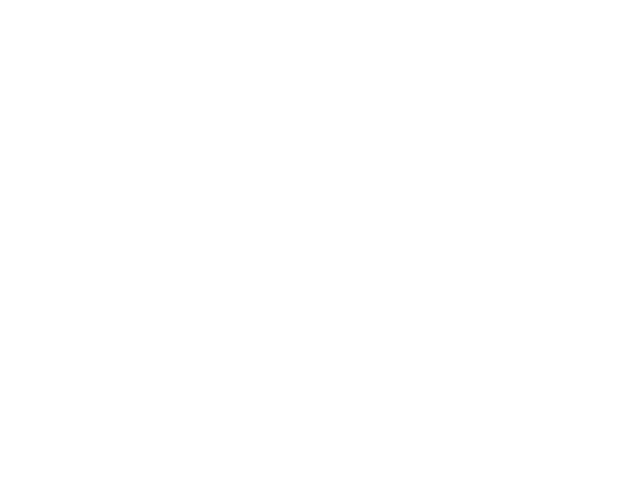

NameError: name 'x' is not defined

In [21]:
plt.figure()
l = plt.plot(x, mean_all_saccades, 'b')
plt.fill_between(x, mean_all_saccades - sd_all_saccades, mean_all_saccades + sd_all_saccades, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)


In [147]:
for val in bin_cs_counts_for_file.values():
    print(bins[np.argmax(val)] - bins[np.argmin(val)])

270.0
-135.0
-225.0
-135.0
-225.0
-180.0
-180.0
45.0
225.0
225.0
-180.0
180.0
90.0
180.0


In [29]:
np.arange(mean_iss.size)

array([0, 1, 2, 3, 4, 5])

<IPython.core.display.Javascript object>


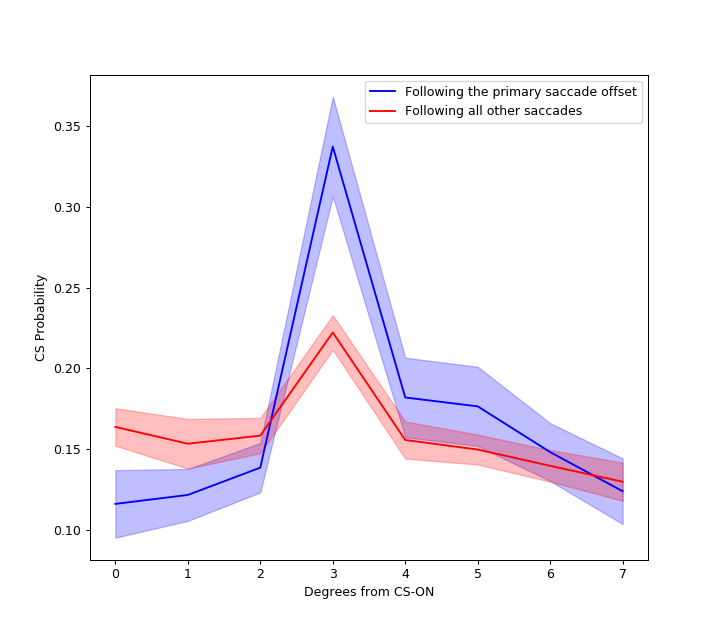

In [14]:

# x = [-180, -90, 0, 90]
plt.figure(figsize=(8,7))


l = plt.plot(mean_iss, 'b')
plt.fill_between(np.arange(mean_iss.size), mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(mean_non_iss, 'r')
plt.fill_between(np.arange(mean_iss.size), mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

# l = plt.plot(x, mean_target_non_iss, 'k')
# plt.fill_between(x, mean_target_non_iss - sd_target_non_iss, mean_target_non_iss + sd_target_non_iss, color=l[0].get_color(), alpha=0.25)

# plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['Following the primary saccade offset', 'Following all other saccades'])

In [25]:
theta = np.array([-135, -90, -45, 0, 45, 90, 135, 180, -135])*np.pi/180

In [16]:
theta = np.array([-135, -90, -45, 0, 45, 90, 135, 180])*np.pi/180


In [25]:
theta = np.arange(-180, 180, 60)*np.pi/180

<IPython.core.display.Javascript object>


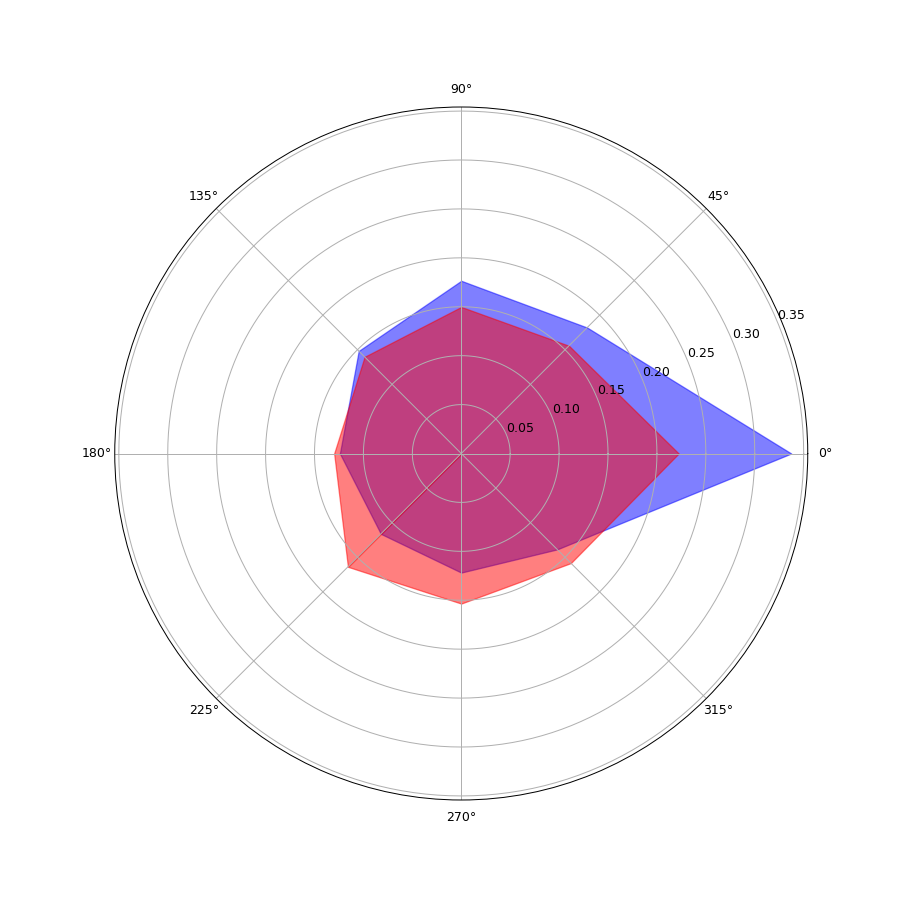

In [19]:
plt.figure(figsize=(10,10))
plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_iss , mean_iss[0])), alpha = 0.02,color = 'b' )
plt.fill_between( np.hstack((theta, theta[0])),0, np.hstack((mean_iss , mean_iss[0])), alpha = 0.5, color = 'b')

plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_non_iss , mean_non_iss[0])), alpha = 0.02,color = 'r' )
plt.fill_between(np.hstack((theta, theta[0])),0, np.hstack((mean_non_iss , mean_non_iss[0])), alpha = 0.5, color = 'r')

In [20]:
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_polar.png')
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_with_polar.svg')


<IPython.core.display.Javascript object>


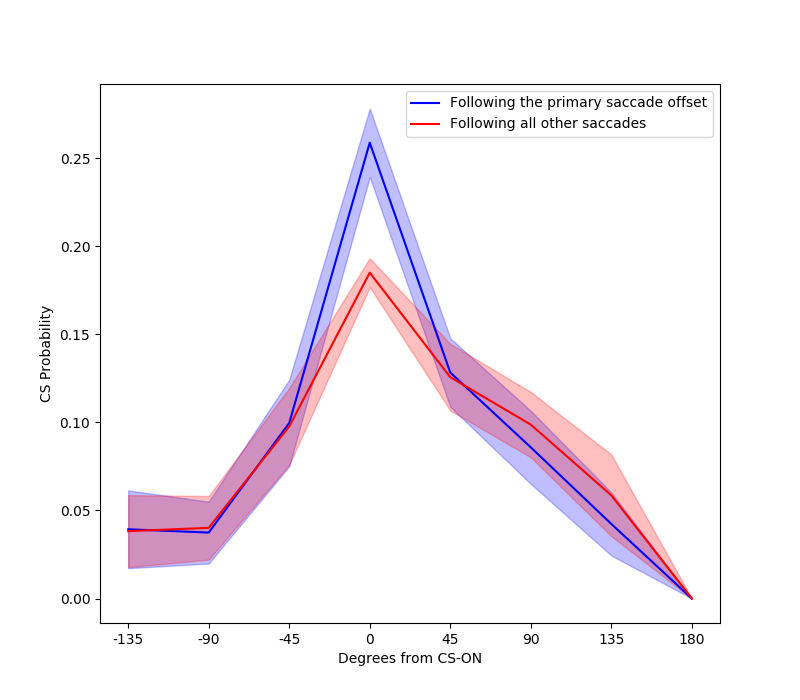

In [40]:
x = [-135, -90, -45, 0, 45, 90, 135, 180]
# x = [-180, -90, 0, 90]
plt.figure(figsize=(8,7))


l = plt.plot(x, mean_iss, 'b')
plt.fill_between(x, mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(x, mean_non_iss, 'r')
plt.fill_between(x, mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

# l = plt.plot(x, mean_target_non_iss, 'k')
# plt.fill_between(x, mean_target_non_iss - sd_target_non_iss, mean_target_non_iss + sd_target_non_iss, color=l[0].get_color(), alpha=0.25)

plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['Following the primary saccade offset', 'Following all other saccades'])

In [130]:
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_with_cue_offset.png')
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_with_cue_offset.svg')
